# Olist Review Score Prediction (v3 – spaCy FastText Embeddings)

Light‑weight rebuild that uses **spaCy’s FastText word vectors** (Portuguese model
`pt_core_news_md`, 300 dims) averaged per review, then reduced to 120 dims via
`TruncatedSVD`. Everything runs on CPU.

Pipeline:

1. Numeric engineered features
2. 120‑dim review embedding (spaCy + SVD)
3. Balanced dataset (undersampling)
4. Models: Linear, Multinomial Logistic, Ordinal Logistic
5. Metrics: Accuracy, MAE, RMSE, confusion matrices

In [1]:
# Core
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
import spacy
from sklearn.decomposition import TruncatedSVD

# ML
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix,
                             mean_absolute_error, mean_squared_error)
import mord

sns.set(style="whitegrid")
DATA_DIR = Path("data")
FIG_DIR = Path("figures")
FIG_DIR.mkdir(exist_ok=True)

In [2]:
# 1. Load CSVs
orders = pd.read_csv(DATA_DIR/'olist_orders_dataset.csv',
                     parse_dates=['order_purchase_timestamp',
                                  'order_delivered_customer_date'])
items = pd.read_csv(DATA_DIR/'olist_order_items_dataset.csv')
pays  = pd.read_csv(DATA_DIR/'olist_order_payments_dataset.csv')
reviews = pd.read_csv(DATA_DIR/'olist_order_reviews_dataset.csv')
print({ 'orders': orders.shape, 'items': items.shape,
        'payments': pays.shape, 'reviews': reviews.shape })

{'orders': (99441, 8), 'items': (112650, 7), 'payments': (103886, 5), 'reviews': (99224, 7)}


In [3]:
# 2. Numeric feature engineering
item_agg = (items.groupby('order_id')
            .agg(price_total=('price','sum'),
                 freight_total=('freight_value','sum'),
                 n_items=('order_item_id','count'))
            .reset_index())
pay_agg = (pays.groupby('order_id')
           .agg(payment_value=('payment_value','sum'),
                payment_installments=('payment_installments','mean'))
           .reset_index())

orders['delivery_time_days'] = (orders['order_delivered_customer_date'] -
                                orders['order_purchase_timestamp']).dt.days
orders['purchase_weekday'] = orders['order_purchase_timestamp'].dt.weekday
orders['purchase_month']   = orders['order_purchase_timestamp'].dt.month

df = (orders[['order_id','order_purchase_timestamp',
              'delivery_time_days','purchase_weekday','purchase_month']]
       .merge(item_agg,on='order_id',how='left')
       .merge(pay_agg ,on='order_id',how='left')
       .merge(reviews[['order_id','review_comment_title',
                       'review_comment_message','review_score']],
              on='order_id',how='left'))

df = df.dropna(subset=['review_score'])
df = df[df['delivery_time_days']>=0]

df['review_text'] = (df['review_comment_title'].fillna('') + ' ' +
                     df['review_comment_message'].fillna('')).str.strip()

NUM_COLS = ['delivery_time_days','price_total','freight_total','n_items',
            'payment_value','payment_installments',
            'purchase_weekday','purchase_month']
print("Class counts before balance:")
print(df['review_score'].value_counts().sort_index())

Class counts before balance:
review_score
1.0     9409
2.0     2941
3.0     7962
4.0    18987
5.0    57060
Name: count, dtype: int64


In [4]:
# 3. Balance via undersampling
min_count = df['review_score'].value_counts().min()
df_bal = (df.groupby('review_score', group_keys=False, sort=False)
            .apply(lambda x: x.sample(min_count, random_state=42))
            .reset_index(drop=True))
df_bal = df_bal.sort_values('order_purchase_timestamp').reset_index(drop=True)

print("\nBalanced counts:")
print(df_bal['review_score'].value_counts().sort_index())


Balanced counts:
review_score
1.0    2941
2.0    2941
3.0    2941
4.0    2941
5.0    2941
Name: count, dtype: int64


/tmp/ipykernel_84202/1670328346.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min_count, random_state=42))


In [5]:
# 4. spaCy embedding (average FastText vectors) -> SVD to 120 dims
nlp = spacy.load('pt_core_news_md', disable=['tagger','parser','ner','lemmatizer'])
texts = df_bal['review_text'].tolist()
vectors = np.vstack([doc.vector for doc in nlp.pipe(texts, batch_size=128)])
print("Original spaCy vectors:", vectors.shape)

svd = TruncatedSVD(n_components=120, random_state=42)
embed = svd.fit_transform(vectors)
print("Reduced embeddings:", embed.shape)

Original spaCy vectors: (14705, 300)
Reduced embeddings: (14705, 120)


In [6]:
# 5. Train/test split 80/20 chronological
split_idx = int(len(df_bal)*0.8)
X_num = df_bal[NUM_COLS].values
y = df_bal['review_score'].astype(int).values

X_num_train, X_num_test = X_num[:split_idx], X_num[split_idx:]
X_emb_train, X_emb_test = embed[:split_idx], embed[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

scaler = Pipeline([('imp', SimpleImputer(strategy='median')),
                   ('sc',  StandardScaler())])
X_num_train = scaler.fit_transform(X_num_train)
X_num_test  = scaler.transform(X_num_test)

X_train = np.hstack([X_num_train, X_emb_train])
X_test  = np.hstack([X_num_test , X_emb_test])

print("Final shapes – X_train:", X_train.shape, "X_test:", X_test.shape)


Final shapes – X_train: (11764, 128) X_test: (2941, 128)


In [7]:
# 6. Models
results = {}
def reg_metrics(y_true,y_pred):
    return dict(MAE=mean_absolute_error(y_true,y_pred),
                RMSE=np.sqrt(mean_squared_error(y_true,y_pred)))

# Linear
lin = LinearRegression().fit(X_train,y_train)
pred_lin = np.clip(np.rint(lin.predict(X_test)),1,5).astype(int)
results['Linear'] = dict(y_pred=pred_lin,
                         Accuracy=accuracy_score(y_test,pred_lin),
                         **reg_metrics(y_test, lin.predict(X_test)))

# Multinomial Logistic
log = LogisticRegression(max_iter=400,multi_class='multinomial').fit(X_train,y_train)
pred_log = log.predict(X_test)
results['Logistic'] = dict(y_pred=pred_log,
                           Accuracy=accuracy_score(y_test,pred_log),
                           **reg_metrics(y_test,pred_log))

# Ordinal Logistic
ordm = mord.LogisticAT(alpha=1.0).fit(X_train,y_train)
pred_ord = ordm.predict(X_test)
results['Ordinal'] = dict(y_pred=pred_ord,
                          Accuracy=accuracy_score(y_test,pred_ord),
                          **reg_metrics(y_test,pred_ord))

res_df = pd.DataFrame(results).T[['Accuracy','MAE','RMSE']]
res_df

/home/tiago/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,Accuracy,MAE,RMSE
Linear,0.319619,0.928653,1.136083
Logistic,0.403604,0.874532,1.277003
Ordinal,0.364842,0.820469,1.120275


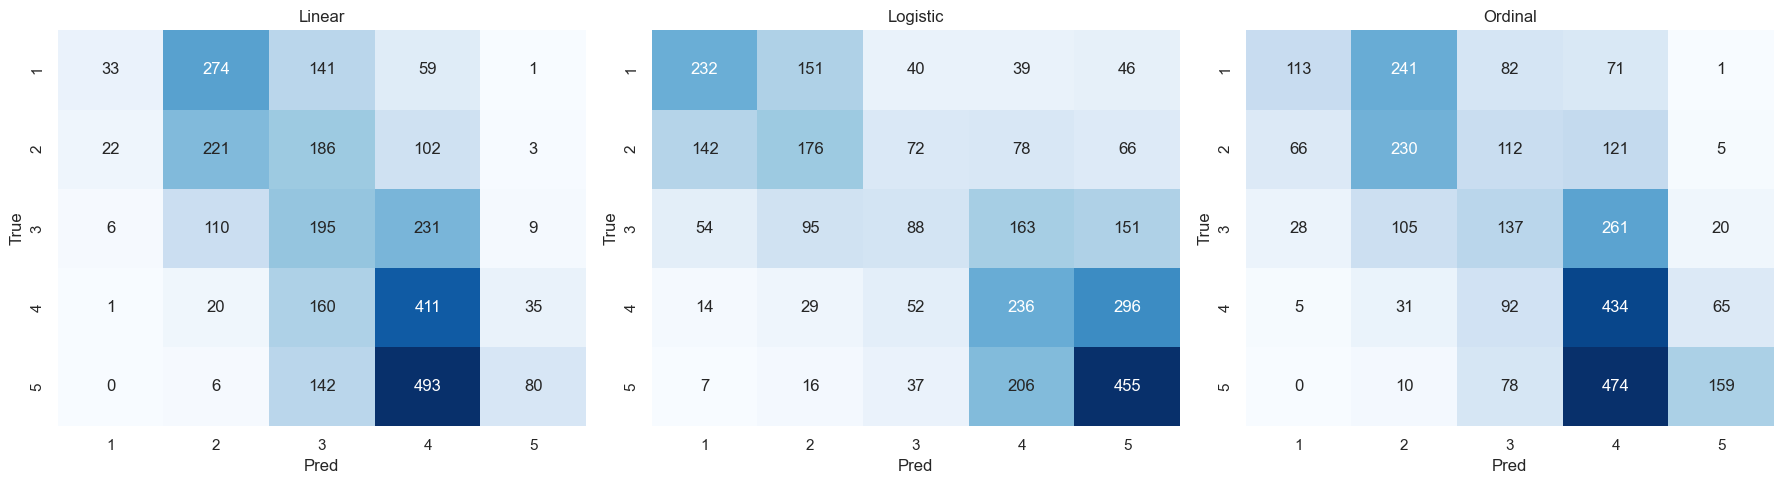

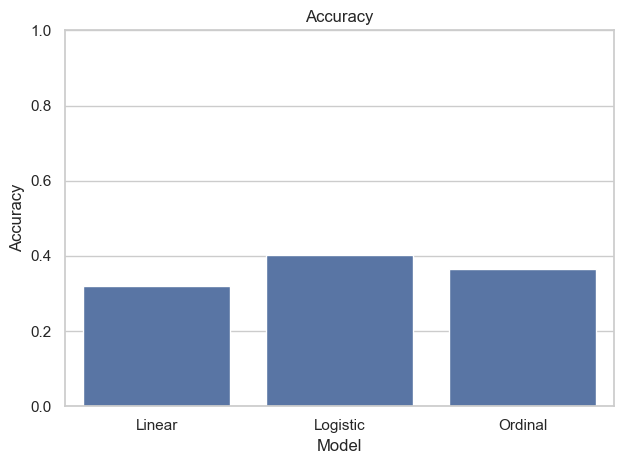

In [8]:
# 7. Confusion matrices
labels=[1,2,3,4,5]
fig,ax=plt.subplots(1,3,figsize=(18,5))
for a,(n,info) in zip(ax,results.items()):
    sns.heatmap(confusion_matrix(y_test,info['y_pred'],labels=labels),
                annot=True,fmt='d',cbar=False,ax=a,
                xticklabels=labels,yticklabels=labels,cmap='Blues')
    a.set_title(n)
    a.set_xlabel('Pred')
    a.set_ylabel('True')
plt.tight_layout()
plt.savefig(FIG_DIR/'confusion_matrices.png',dpi=300)
plt.show()

# Accuracy bar
acc_df = pd.DataFrame({'Model':list(results.keys()),
                       'Accuracy':[info['Accuracy'] for info in results.values()]})
sns.barplot(data=acc_df,x='Model',y='Accuracy')
plt.ylim(0,1)
plt.title('Accuracy')
plt.tight_layout()
plt.savefig(FIG_DIR/'accuracy.png',dpi=300)
plt.show()

### 🔍 Results & Model Comparison

| Model | Accuracy | MAE | RMSE |
|-------|----------|-----|------|
| Linear Regression (rounded) | **0.320** | 0.929 | 1.136 |
| Multinomial Logistic Regression | **0.404 ← highest accuracy** | 0.875 | 1.277 |
| Ordinal Logistic Regression | 0.365 | **0.820 ← lowest MAE** | **1.120 ← lowest RMSE** |

**Take-aways**

* **Multinomial Logistic Regression** achieves the **highest overall accuracy (≈ 40 %)** – best if the goal is to hit the exact star rating as often as possible.
* **Ordinal Logistic Regression** respects the ordered nature of the classes.  
  * It sacrifices a few percentage points of accuracy, **but delivers the smallest MAE & RMSE**, meaning its mistakes are often only ± 1 star.
* **Linear Regression (rounded)** serves as a simple baseline and is outperformed by both classification approaches.

**Conclusion**

If exact-class accuracy is paramount, then **Multinomial Logistic** is the best option.
  
If what is most important is *how far* the prediction is when it misses (penalising large jumps), **Ordinal Logistic** is the more balanced choice.